In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import accuracy, f1_score


In [2]:
horrorDF = pd.read_excel(
    "2조 괴담 파일.xlsx", skiprows=0, header=1, sheet_name="SY", usecols=[3]
)


In [3]:
horrorDF


,TEXT
0,오늘 학교에서 모의고사보는데 가위눌리다가 한쪽눈만 떠진상태로 교실에서 내 다리에 올...
1,그녀는 날 사랑한다... 안 사랑한다... 날 사랑한다... 안 사랑한다...날 사...
2,"어린애같지만, 난 항상 지하실에서 나갈때 내 뒤를 쳐다보면서 계단을 뛰어 올라가. ..."
3,생리혈에 덩어리 같은게 있을수 있다는건 나도 알아. 근데 그게 보통 움직이는거야?\n
4,"난 별 생각없이 ""우리 모두 다함께 손뼉쳐!"" 라고 외쳤어. 다락방에서 박수 소리를..."
...,...
994,희망봉근해에 출몰하는 네덜란드 동인도회사의 유령선을 플라잉더치맨이라고 부른다. 알류...
995,"T 씨가 잠에서 깨자, 1년이 경과해있었다.하지만 기억상실은 아니다.가족도, 친구도..."
996,아르메니아 쿠니크호수에는 딱 스와코 *오미와타리 같은 자연현상이 일어난다. 호반 교...
997,"적도상 3만 6000킬로에 해당하는 우주 공간에, 길이 50M의 거대 물체가 떠있..."


In [4]:
horrorSR = horrorDF["TEXT"].str.replace(r"[^가-힣a-zA-Z\d ]", "", regex=True)
horrorSR.info()


<class 'pandas.core.series.Series'>
RangeIndex: 999 entries, 0 to 998
Series name: TEXT
Non-Null Count  Dtype 
--------------  ----- 
999 non-null    object
dtypes: object(1)
memory usage: 7.9+ KB


In [5]:
sentences = horrorSR.to_list()[:100]
sentences


['오늘 학교에서 모의고사보는데 가위눌리다가 한쪽눈만 떠진상태로 교실에서 내 다리에 올라와있는 귀신봤어',
 '그녀는 날 사랑한다 안 사랑한다 날 사랑한다 안 사랑한다날 사 어 더 이상 떼어낼 팔다리가 없네 넌 처음부터 날 사랑하지 않았구나',
 '어린애같지만 난 항상 지하실에서 나갈때 내 뒤를 쳐다보면서 계단을 뛰어 올라가 난 잘못된 방향을 바라보고 있었었어',
 '생리혈에 덩어리 같은게 있을수 있다는건 나도 알아 근데 그게 보통 움직이는거야',
 '난 별 생각없이 우리 모두 다함께 손뼉쳐 라고 외쳤어 다락방에서 박수 소리를 들리기 전까진 난 내가 집에 혼자있는줄 알았어',
 '난 숲속에서 일회용 카메라를 발견했다 필름을 현상했을때 그곳엔 내가 처음으로 카메라를 발견했을때의 모습이 찍힌 사진 딱 한장만이 찍혀있었다',
 '우리 할머니는 심한 치매에 걸리셨다 매일 저녁 난 할머니가 2년전에 이미 돌아가셨다고 설명하지만 허사다',
 '버스 문이 닫히고 버스 기사의 웃음소리가 그의 뒤에서 울려퍼졌을때 지미는 자신의 실수를 알아챘다 왜 스쿨 버스가 한밤중에 달리고 있는거지',
 '저녁시간 아빠는 나에게 하루가 어땠는지 물었다 아빠의 얼굴이 약간 정중앙에서 벗어나있는것처럼 보인다는 사실을 깨달았을때 난 아빠의 어깨 너머로 도망가라고 입모양으로 말하고 있는 두려움에 빠진 엄마를 볼수 있었다',
 '아빠 나 무서운 꿈 꿨어 오 공주님 난 아빠가 아냐',
 '아내는 계속 나한테 딸이 2년전에 죽었다는 사실을 납득시키려고 했다 우리가 이 이야기로 다투고 있을때 작은 목소리가 들려왔다 누구랑 얘기하고 있는거야 아빠 ',
 '수업시간에 나한테 잘해줘서 정말 고마워 내일 안전한 사람은 너뿐일거야',
 '내 스마트워치 기록이 무서워 왜 내 심장이 매일 밤 새벽 3시에 멈추는거야',
 '사람들이 날 보면 내가 엄마 눈을 가졌다고 하더라 웃긴건 말야 난 엄마 심장도 지금 가지고 있어',
 '매일 밤 잠자리에 들기전에 난 앞문이 단단히 잠겼는지 항상 확인해 마침내 오늘밤 그녀가 까먹은것

In [6]:
sentence_dot = ".".join(sentences) + "."
sentence_dot


'오늘 학교에서 모의고사보는데 가위눌리다가 한쪽눈만 떠진상태로 교실에서 내 다리에 올라와있는 귀신봤어.그녀는 날 사랑한다 안 사랑한다 날 사랑한다 안 사랑한다날 사 어 더 이상 떼어낼 팔다리가 없네 넌 처음부터 날 사랑하지 않았구나.어린애같지만 난 항상 지하실에서 나갈때 내 뒤를 쳐다보면서 계단을 뛰어 올라가 난 잘못된 방향을 바라보고 있었었어.생리혈에 덩어리 같은게 있을수 있다는건 나도 알아 근데 그게 보통 움직이는거야.난 별 생각없이 우리 모두 다함께 손뼉쳐 라고 외쳤어 다락방에서 박수 소리를 들리기 전까진 난 내가 집에 혼자있는줄 알았어.난 숲속에서 일회용 카메라를 발견했다 필름을 현상했을때 그곳엔 내가 처음으로 카메라를 발견했을때의 모습이 찍힌 사진 딱 한장만이 찍혀있었다.우리 할머니는 심한 치매에 걸리셨다 매일 저녁 난 할머니가 2년전에 이미 돌아가셨다고 설명하지만 허사다.버스 문이 닫히고 버스 기사의 웃음소리가 그의 뒤에서 울려퍼졌을때 지미는 자신의 실수를 알아챘다 왜 스쿨 버스가 한밤중에 달리고 있는거지.저녁시간 아빠는 나에게 하루가 어땠는지 물었다 아빠의 얼굴이 약간 정중앙에서 벗어나있는것처럼 보인다는 사실을 깨달았을때 난 아빠의 어깨 너머로 도망가라고 입모양으로 말하고 있는 두려움에 빠진 엄마를 볼수 있었다.아빠 나 무서운 꿈 꿨어 오 공주님 난 아빠가 아냐.아내는 계속 나한테 딸이 2년전에 죽었다는 사실을 납득시키려고 했다 우리가 이 이야기로 다투고 있을때 작은 목소리가 들려왔다 누구랑 얘기하고 있는거야 아빠 .수업시간에 나한테 잘해줘서 정말 고마워 내일 안전한 사람은 너뿐일거야.내 스마트워치 기록이 무서워 왜 내 심장이 매일 밤 새벽 3시에 멈추는거야.사람들이 날 보면 내가 엄마 눈을 가졌다고 하더라 웃긴건 말야 난 엄마 심장도 지금 가지고 있어.매일 밤 잠자리에 들기전에 난 앞문이 단단히 잠겼는지 항상 확인해 마침내 오늘밤 그녀가 까먹은것 같으니 이제 집안으로 들어갈수 있겠어 .난 오 하느님 맙소사 내가 지구의 마지막 사람이 아니었어 라고

In [ ]:
# import pickle

# with open("char_set.pkl", "rb") as f:
#     char_set = pickle.load(f)


In [14]:
char_set = list(set(sentence_dot))
char_to_id = {char: idx for idx, char in enumerate(char_set)}
id_to_char = {idx: char for idx, char in enumerate(char_set)}
dict_size = len(char_to_id)
dict_size


641

In [15]:
import pickle

with open("char_set.pkl", "wb") as f:
    pickle.dump(char_set, f)


In [16]:
X_data, y_data = [], []
sequence_length = 10

for i in range(0, len(sentence_dot) - sequence_length):
    x_str = sentence_dot[i : i + sequence_length]
    y_str = sentence_dot[i + 1 : i + sequence_length + 1]
    # print(i, x_str, '->', y_str)
    X_data.append([char_to_id[c] for c in x_str])
    y_data.append([char_to_id[c] for c in y_str])


In [17]:
X_data[0], y_data[0]


([126, 355, 552, 620, 308, 162, 592, 552, 111, 470],
 [355, 552, 620, 308, 162, 592, 552, 111, 470, 10])

In [18]:
print(
    f"입력 데이터 size: {len(X_data)}, shape: {np.array(X_data).shape}, dim: {np.array(X_data).ndim}"
)
print(
    f"출력 데이터 size: {len(y_data)}, shape: {np.array(y_data).shape}, dim: {np.array(y_data).ndim}"
)


입력 데이터 size: 8618, shape: (8618, 10), dim: 2
출력 데이터 size: 8618, shape: (8618, 10), dim: 2


In [19]:
class CharDataset(Dataset):
    def __init__(
        self,
        X_data,
        y_data,
    ) -> None:
        super().__init__()
        self.in_text = torch.FloatTensor(X_data)
        self.out_text = torch.FloatTensor(y_data)

    def __len__(self):
        return len(self.out_text)

    def __getitem__(self, index):
        return self.in_text[index], self.out_text[index]


In [20]:
class CharGRU(nn.Module):
    def __init__(self, dict_size, hidden_size, n_layers) -> None:
        super().__init__()
        self.gru = nn.GRU(
            input_size=dict_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.linear = nn.Linear(hidden_size * 2, dict_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.linear.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()

    def forward(self, text):
        output, _ = self.gru(text)
        return self.linear(output)


In [21]:
batch_size = 256
dict_size = len(char_to_id)
hidden_size = 64
n_layer = 2
lr = 0.001

learningDS = CharDataset(X_data, y_data)
learningDL = DataLoader(dataset=learningDS, batch_size=batch_size, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = CharGRU(dict_size, hidden_size, n_layer).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(classifier.parameters(), lr)
schduler = optim.lr_scheduler.StepLR(optimizer, 1000, 0.1)

print(len(learningDL))


34


In [22]:
from torchinfo import summary

summary(classifier)


Layer (type:depth-idx)                   Param #
CharGRU                                  --
├─GRU: 1-1                               345,984
├─Linear: 1-2                            82,689
Total params: 428,673
Trainable params: 428,673
Non-trainable params: 0

In [23]:
from tqdm import tqdm


def learning(
    epoch, epochs, model, dataLoader, criterion, optimizer, device, mode="train"
):
    if mode == "train":
        model.train()
        is_train = True
    elif mode == "test":
        model.eval()
        is_train = False
    else:
        raise ValueError("Invalid mode. Must be 'train' or 'test'")

    loss_list = []
    acc_list = []
    f1_list = []
    running_loss = 0.0

    with torch.set_grad_enabled(is_train):
        pbar = tqdm(enumerate(dataLoader), total=len(dataLoader))
        for step, (in_text, out_text) in pbar:
            in_text, out_text = in_text.to(device), out_text.to(device)
            oh_in_text = F.one_hot(in_text.long(), dict_size).float()
            oh_out_text = F.one_hot(out_text.long(), dict_size).float()
            pre_text = model(oh_in_text)
            loss = criterion(pre_text, oh_out_text)
            running_loss += loss.item()
            acc_list.append(
                accuracy(
                    pre_text.argmax(2),
                    out_text,
                    task="multiclass",
                    num_classes=dict_size,
                ).item()
            )
            f1_list.append(
                f1_score(
                    pre_text.argmax(2),
                    out_text,
                    task="multiclass",
                    num_classes=dict_size,
                    average="macro",
                ).item()
            )
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                optimizer.step()
                loss_list.append(loss.item())
                if step % 10 == 9:
                    pbar.set_description(
                        f"Epoch [{epoch + 1}/{epochs}], 횟수 [{step + 1}/{len(dataLoader)}], Loss: {running_loss/10:.4f}"
                    )
                    running_loss = 0.0
    return np.mean(loss_list), np.mean(acc_list), np.mean(f1_list)


In [24]:
def predict(model, word):
    pred_text = []
    for char in word:
        if char in char_to_id.keys():
            pred_text.append(
                F.one_hot(torch.tensor(char_to_id[char]), dict_size).float()
            )
        else:
            pred_text.append(
                F.one_hot(torch.tensor(char_to_id[" "]), dict_size).float()
            )
    pred_text = torch.stack(pred_text).to(device)
    model.eval()
    with torch.no_grad():
        pred_num = model(pred_text).argmax(1).tolist()
        result = "".join([id_to_char[i] for i in pred_num])
    return result


In [25]:
def make_sentence(model, start, num=100, stopword="."):
    sentence = start
    for _ in range(num):
        next_char = predict(model, sentence[-10:])
        sentence += next_char[-1]
        if next_char[-1] == stopword:
            break
    return sentence


In [26]:
scoreList = [[], [], []]
resultList = []


In [27]:
schduler = optim.lr_scheduler.StepLR(optimizer, 100, 0.1)


In [28]:
epochs = 250
for epoch in range(epochs):
    loss, acc, f1 = learning(
        epoch,
        epochs,
        classifier,
        learningDL,
        criterion,
        optimizer,
        device,
        mode="train",
    )
    # schduler.step()
    print(make_sentence(classifier, "오늘 학교에서 모의"))
    scoreList[0].append(loss), scoreList[1].append(acc), scoreList[2].append(f1)
    torch.save(classifier, "classifier_20_256.pt")


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [1/250], 횟수 [30/34], Loss: 0.0321: 100%|██████████| 34/34 [00:02<00:00, 11.98it/s]


오늘 학교에서 모의2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222


Epoch [2/250], 횟수 [30/34], Loss: 0.0217: 100%|██████████| 34/34 [00:02<00:00, 12.47it/s]


오늘 학교에서 모의 사빌베니 말무무무22베베니 사빌베니 말무무무22베베니 사빌베니 말무무무22베베니 사빌베니 말무무무22베베니 사빌베니 말무무무22베베니 사빌베니 말무무무22베베니 사빌베니 말무무무


Epoch [3/250], 횟수 [30/34], Loss: 0.0136: 100%|██████████| 34/34 [00:02<00:00, 12.22it/s]


오늘 학교에서 모의낼국무무무로낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무베니낼낼붙무


Epoch [4/250], 횟수 [30/34], Loss: 0.0091: 100%|██████████| 34/34 [00:02<00:00, 11.65it/s]


오늘 학교에서 모의2지만니다.


Epoch [5/250], 횟수 [30/34], Loss: 0.0071: 100%|██████████| 34/34 [00:02<00:00, 11.85it/s]


오늘 학교에서 모의하지만니까있는데비명간의 빌었습니고.


Epoch [6/250], 횟수 [30/34], Loss: 0.0061: 100%|██████████| 34/34 [00:02<00:00, 11.43it/s]


오늘 학교에서 모의하지만니까있지만매가있지지.


Epoch [7/250], 횟수 [30/34], Loss: 0.0055: 100%|██████████| 34/34 [00:03<00:00,  9.71it/s]


오늘 학교에서 모의하지만니까있지만매가있지지.


Epoch [8/250], 횟수 [30/34], Loss: 0.0051: 100%|██████████| 34/34 [00:03<00:00, 10.67it/s]


오늘 학교에서 모의하지만니까있지만매가있지지.


Epoch [9/250], 횟수 [30/34], Loss: 0.0050: 100%|██████████| 34/34 [00:03<00:00, 10.59it/s]


오늘 학교에서 모의하지만니다.


Epoch [10/250], 횟수 [30/34], Loss: 0.0048: 100%|██████████| 34/34 [00:03<00:00, 10.33it/s]


오늘 학교에서 모의하지만니까있지만매가있지구았다.


Epoch [11/250], 횟수 [30/34], Loss: 0.0047: 100%|██████████| 34/34 [00:03<00:00, 10.19it/s]


오늘 학교에서 모의사실에서 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게


Epoch [12/250], 횟수 [30/34], Loss: 0.0046: 100%|██████████| 34/34 [00:03<00:00, 10.77it/s]


오늘 학교에서 모의사실에서 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게


Epoch [13/250], 횟수 [30/34], Loss: 0.0046: 100%|██████████| 34/34 [00:03<00:00, 10.64it/s]


오늘 학교에서 모의사실에서 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게눈에게 빌어가에게


Epoch [14/250], 횟수 [30/34], Loss: 0.0045: 100%|██████████| 34/34 [00:03<00:00,  9.88it/s]


오늘 학교에서 모의사실한다.


Epoch [15/250], 횟수 [30/34], Loss: 0.0045: 100%|██████████| 34/34 [00:03<00:00, 10.40it/s]


오늘 학교에서 모의사실한다.


Epoch [16/250], 횟수 [30/34], Loss: 0.0044: 100%|██████████| 34/34 [00:03<00:00, 10.63it/s]


오늘 학교에서 모의사실한다.


Epoch [17/250], 횟수 [30/34], Loss: 0.0044: 100%|██████████| 34/34 [00:03<00:00, 10.05it/s]


오늘 학교에서 모의사실한다.


Epoch [18/250], 횟수 [30/34], Loss: 0.0043: 100%|██████████| 34/34 [00:03<00:00, 10.51it/s]


오늘 학교에서 모의사실한다.


Epoch [19/250], 횟수 [30/34], Loss: 0.0044: 100%|██████████| 34/34 [00:03<00:00, 10.63it/s]


오늘 학교에서 모의사실한다.


Epoch [20/250], 횟수 [30/34], Loss: 0.0044: 100%|██████████| 34/34 [00:03<00:00, 10.33it/s]


오늘 학교에서 모의사실한다.


Epoch [21/250], 횟수 [30/34], Loss: 0.0043: 100%|██████████| 34/34 [00:03<00:00, 10.55it/s]


오늘 학교에서 모의사실한다.


Epoch [22/250], 횟수 [30/34], Loss: 0.0043: 100%|██████████| 34/34 [00:03<00:00, 10.47it/s]


오늘 학교에서 모의사실한다.


Epoch [23/250], 횟수 [30/34], Loss: 0.0043: 100%|██████████| 34/34 [00:03<00:00, 10.65it/s]


오늘 학교에서 모의사실한다.


Epoch [24/250], 횟수 [30/34], Loss: 0.0043: 100%|██████████| 34/34 [00:03<00:00, 10.76it/s]


오늘 학교에서 모의사실한다.


Epoch [25/250], 횟수 [30/34], Loss: 0.0043: 100%|██████████| 34/34 [00:03<00:00, 10.24it/s]


오늘 학교에서 모의사실한다.


Epoch [26/250], 횟수 [30/34], Loss: 0.0042: 100%|██████████| 34/34 [00:03<00:00, 10.62it/s]


오늘 학교에서 모의사실한다.


Epoch [27/250], 횟수 [30/34], Loss: 0.0042: 100%|██████████| 34/34 [00:03<00:00, 10.34it/s]


오늘 학교에서 모의사실한다.


Epoch [28/250], 횟수 [30/34], Loss: 0.0042: 100%|██████████| 34/34 [00:03<00:00, 10.09it/s]


오늘 학교에서 모의사실한다.


Epoch [29/250], 횟수 [30/34], Loss: 0.0042: 100%|██████████| 34/34 [00:03<00:00,  9.31it/s]


오늘 학교에서 모의사실한다.


Epoch [30/250], 횟수 [30/34], Loss: 0.0042: 100%|██████████| 34/34 [00:03<00:00,  9.45it/s]


오늘 학교에서 모의사실한다.


Epoch [31/250], 횟수 [30/34], Loss: 0.0042: 100%|██████████| 34/34 [00:03<00:00, 10.85it/s]


오늘 학교에서 모의사실한다.


Epoch [32/250], 횟수 [30/34], Loss: 0.0042: 100%|██████████| 34/34 [00:03<00:00, 10.55it/s]


오늘 학교에서 모의사실한다.


Epoch [33/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:03<00:00, 10.76it/s]


오늘 학교에서 모의사실한다.


Epoch [34/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:03<00:00, 10.28it/s]


오늘 학교에서 모의사실한다.


Epoch [35/250], 횟수 [30/34], Loss: 0.0042: 100%|██████████| 34/34 [00:03<00:00,  9.99it/s]


오늘 학교에서 모의사실한다.


Epoch [36/250], 횟수 [30/34], Loss: 0.0042: 100%|██████████| 34/34 [00:03<00:00, 10.81it/s]


오늘 학교에서 모의사실한다.


Epoch [37/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:03<00:00,  9.99it/s]


오늘 학교에서 모의사실한다.


Epoch [38/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:03<00:00, 10.09it/s]


오늘 학교에서 모의사실한다.


Epoch [39/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:03<00:00,  9.99it/s]


오늘 학교에서 모의사실한다.


Epoch [40/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:03<00:00, 10.11it/s]


오늘 학교에서 모의사실한다.


Epoch [41/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:03<00:00,  9.66it/s]


오늘 학교에서 모의사실한다.


Epoch [42/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:03<00:00, 10.04it/s]


오늘 학교에서 모의사실한다.


Epoch [43/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:03<00:00,  9.34it/s]


오늘 학교에서 모의사실한다.


Epoch [44/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:04<00:00,  8.40it/s]


오늘 학교에서 모의사실한다.


Epoch [45/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:04<00:00,  8.34it/s]


오늘 학교에서 모의사실한다.


Epoch [46/250], 횟수 [30/34], Loss: 0.0042: 100%|██████████| 34/34 [00:03<00:00,  8.93it/s]


오늘 학교에서 모의사실한다.


Epoch [47/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:04<00:00,  7.78it/s]


오늘 학교에서 모의사실한다.


Epoch [48/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:04<00:00,  8.17it/s]


오늘 학교에서 모의사실한다.


Epoch [49/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:04<00:00,  7.51it/s]


오늘 학교에서 모의사실한다.


Epoch [50/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:04<00:00,  8.33it/s]


오늘 학교에서 모의사가하지만니까지난 말하지만니까지난 말하지만니까지난 말하지만니까지난 말하지만니까지난 말하지만니까지난 말하지만니까지난 말하지만니까지난 말하지만니까지난 말하지만니까지난 말하지만니까지난 


Epoch [51/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.70it/s]


오늘 학교에서 모의사실만날 아정하지만니까지난 내떻게소빠을텐고.


Epoch [52/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


오늘 학교에서 모의사실한다.


Epoch [53/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:04<00:00,  7.44it/s]


오늘 학교에서 모의사실만니다.


Epoch [54/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


오늘 학교에서 모의사실만날 아정하지만니까지난 내떻게소빠을텐고.


Epoch [55/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:05<00:00,  6.61it/s]


오늘 학교에서 모의사가하지만니까지난 내떻게소빠을텐고.


Epoch [56/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:05<00:00,  6.63it/s]


오늘 학교에서 모의사실만니까지난 내떻게소빠을텐고.


Epoch [57/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:05<00:00,  6.48it/s]


오늘 학교에서 모의사실만니까지난 내가소빠을때 빌리에게두기어나한다.


Epoch [58/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:05<00:00,  6.17it/s]


오늘 학교에서 모의사가한다.


Epoch [59/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s]


오늘 학교에서 모의사가하지만니까지난 내떻게소빠을텐고.


Epoch [60/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:05<00:00,  6.07it/s]


오늘 학교에서 모의사가하지만니까지난 내떻게소빠을텐고.


Epoch [61/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:05<00:00,  6.70it/s]


오늘 학교에서 모의사가하지만니까지난 내떻게소빠을텐고.


Epoch [62/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:05<00:00,  6.50it/s]


오늘 학교에서 모의사실만니까있지난 내떻게소진했을때 내가소빠을텐고.


Epoch [63/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  6.92it/s]


오늘 학교에서 모의사가하지만니까지난 내가소빠을텐고.


Epoch [64/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.37it/s]


오늘 학교에서 모의사가하지만니까지난 내 발질하지만니까있는것이웃으로 내가소빠을텐고.


Epoch [65/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:04<00:00,  7.39it/s]


오늘 학교에서 모의사가하지만니까지난 내가소빠을텐고.


Epoch [66/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


오늘 학교에서 모의사실만니까지난 내가소빠을 빌리가 소리를웃치다.


Epoch [67/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.73it/s]


오늘 학교에서 모의사실만니까지난 내떻게소빠을텐고.


Epoch [68/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  8.74it/s]


오늘 학교에서 모의사가한다.


Epoch [69/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:03<00:00,  8.79it/s]


오늘 학교에서 모의사실만니까지난 내떻게소빠을텐고.


Epoch [70/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.32it/s]


오늘 학교에서 모의사가하지만니까지난 내가소빠을 빌리가 소신을고.


Epoch [71/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.21it/s]


오늘 학교에서 모의사가한다.


Epoch [72/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00, 10.35it/s]


오늘 학교에서 모의사실만니까지난 내 소신을고.


Epoch [73/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:03<00:00,  9.64it/s]


오늘 학교에서 모의사실만니까지난 내 소신을고.


Epoch [74/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.69it/s]


오늘 학교에서 모의사실만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니


Epoch [75/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.63it/s]


오늘 학교에서 모의사가하지만니까지난 내가소빠을때 빌리에게두기어얻다.


Epoch [76/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.76it/s]


오늘 학교에서 모의사가한다.


Epoch [77/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.76it/s]


오늘 학교에서 모의사실만니까지난 내 소신을고.


Epoch [78/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.66it/s]


오늘 학교에서 모의사실만니다.


Epoch [79/250], 횟수 [30/34], Loss: 0.0041: 100%|██████████| 34/34 [00:03<00:00,  9.90it/s]


오늘 학교에서 모의사가하지만니까지난 내 소신을고.


Epoch [80/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  8.86it/s]


오늘 학교에서 모의사실만니까지난 내 소신을고.


Epoch [81/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.37it/s]


오늘 학교에서 모의사실만니까지난 내 소신을고.


Epoch [82/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.79it/s]


오늘 학교에서 모의사실만니까지난 내 소신을고.


Epoch [83/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.74it/s]


오늘 학교에서 모의사가한다.


Epoch [84/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.45it/s]


오늘 학교에서 모의사실만니까지난 내 소신을고.


Epoch [85/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.28it/s]


오늘 학교에서 모의사가하지만니까지난 내 소신을고.


Epoch [86/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  8.72it/s]


오늘 학교에서 모의사가하지만니까지난 내 소신을고.


Epoch [87/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  8.48it/s]


오늘 학교에서 모의사실만니까지난 내 소신을고.


Epoch [88/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  8.26it/s]


오늘 학교에서 모의사가한다.


Epoch [89/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.12it/s]


오늘 학교에서 모의사가한다.


Epoch [90/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.77it/s]


오늘 학교에서 모의사실만니까지난 내 소신을고.


Epoch [91/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  8.45it/s]


오늘 학교에서 모의사실만니까지난 내 소신을고.


Epoch [92/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.19it/s]


오늘 학교에서 모의사실만니까지난 내 소신을고.


Epoch [93/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  8.16it/s]


오늘 학교에서 모의사실만니까지난 내 소진했을때.


Epoch [94/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.36it/s]


오늘 학교에서 모의사를한다.


Epoch [95/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.62it/s]


오늘 학교에서 모의사실만니까지난 내 소진했을때.


Epoch [96/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


오늘 학교에서 모의사실만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니


Epoch [97/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


오늘 학교에서 모의사실만니까지난 내 소신을고.


Epoch [98/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:05<00:00,  6.78it/s]


오늘 학교에서 모의사실만니까지난 내 소진했을때.


Epoch [99/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


오늘 학교에서 모의사실만니까지난 내 소리를웃으면때.


Epoch [100/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


오늘 학교에서 모의사를한다.


Epoch [101/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  6.99it/s]


오늘 학교에서 모의사실만니까지난 내 발질하지만니까지난 내 소리를웃으면때.


Epoch [102/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:05<00:00,  6.56it/s]


오늘 학교에서 모의사실만니까지난 내 발질하지만니까보지만 내가지만을 빌미에게두기증다.


Epoch [103/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.56it/s]


오늘 학교에서 모의사를한다.


Epoch [104/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.99it/s]


오늘 학교에서 모의사실만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니


Epoch [105/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.62it/s]


오늘 학교에서 모의사실만니까지난 내 소진했을때.


Epoch [106/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  8.83it/s]


오늘 학교에서 모의사실만니까지난 내 소진했을때.


Epoch [107/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.47it/s]


오늘 학교에서 모의사실만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니까지난 내 발질하지만니


Epoch [108/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  8.75it/s]


오늘 학교에서 모의사실만니까지난 내 발질하지만니까보지 내가자살을 박곳는지만 내가 소빠을텐고.


Epoch [109/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.79it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로 내가자살을 박곳는지만 내가를웃으로 내가자살을 박곳는지만 내가를웃으로 내가자살을 박곳는지만 내가를웃으로 내가자살을 박곳는지만 내가를웃으로 내가자살을 박곳는지


Epoch [110/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.75it/s]


오늘 학교에서 모의사실만니까지난 내 소진했을때.


Epoch [111/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.54it/s]


오늘 학교에서 모의사실만니까지난 내 소진했을때.


Epoch [112/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.60it/s]


오늘 학교에서 모의사실만니까지난 내 발질하지만니까보지만 내가지만을 붙잡았던.


Epoch [113/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.79it/s]


오늘 학교에서 모의사실만니까지난 내 소진했을때.


Epoch [114/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.25it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로 내가소빠을 붙잡았던.


Epoch [115/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.97it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 내가소빠을 붙잡았습니다.


Epoch [116/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.54it/s]


오늘 학교에서 모의사실만니까지난 내 소리를웃으면때.


Epoch [117/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.88it/s]


오늘 학교에서 모의사실만니까지난 내 소진했을때.


Epoch [118/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.64it/s]


오늘 학교에서 모의사실만니까지난 내 당신하지만니까지난 내 당신하지만니까지난 내 당신하지만니까지난 내 당신하지만니까지난 내 당신하지만니까지난 내 당신하지만니까지난 내 당신하지만니까지난 내 당신하지만니


Epoch [119/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00, 10.54it/s]


오늘 학교에서 모의사실만니까지난 내 소리를웃으면때.


Epoch [120/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.23it/s]


오늘 학교에서 모의사실만니까지난 내 발질하지만니까보지만 내가지만을 빌미에게두기증다.


Epoch [121/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.80it/s]


오늘 학교에서 모의사를한다.


Epoch [122/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.36it/s]


오늘 학교에서 모의사를한다.


Epoch [123/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.15it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [124/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00, 10.02it/s]


오늘 학교에서 모의사실만니까지난 내 수소진를웃으면때 살짜리를 발굴을텐데에겐 찍었지만니까지난 내 수소진를웃으면때 살짜리를 발굴을텐데에겐 찍었지만니까지난 내 수소진를웃으면때 살짜리를 발굴을텐데에겐 찍었


Epoch [125/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.58it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [126/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.02it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 내가소빠을 붙잡았던.


Epoch [127/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.68it/s]


오늘 학교에서 모의사를한다.


Epoch [128/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.54it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 내가자살을 박속했지만 내가방 밖을눈날 비명을 꺼낼가고 잠에게두기다.


Epoch [129/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  8.98it/s]


오늘 학교에서 모의사실만니까지난 내 발울로 말의했다.


Epoch [130/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  8.46it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 내가소빠을 붙잡았습니다.


Epoch [131/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.86it/s]


오늘 학교에서 모의사를한다.


Epoch [132/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.93it/s]


오늘 학교에서 모의사를웃치보서야.


Epoch [133/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  8.02it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [134/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.75it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [135/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  6.90it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [136/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.63it/s]


오늘 학교에서 모의사를한다.


Epoch [137/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.14it/s]


오늘 학교에서 모의사실만니까있지.


Epoch [138/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 내가자살을 박곳는데건웃으로 내가 소속한지만않기증자.


Epoch [139/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:05<00:00,  6.43it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [140/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:05<00:00,  6.35it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [141/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s]


오늘 학교에서 모의사실만니까지난 내 발울로를 박수했을때 사간한다.


Epoch [142/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:05<00:00,  6.80it/s]


오늘 학교에서 모의사실만니까있는것무의웃으다.


Epoch [143/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [144/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


오늘 학교에서 모의사실만니까지난 내 발울로를 박수했을때 사간한다.


Epoch [145/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.24it/s]


오늘 학교에서 모의사실만니까지난 내 발울로 말의자기로 느간이웃으면때 박자나는웃으로한 .


Epoch [146/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  8.84it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [147/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  8.37it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [148/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  8.75it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [149/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.66it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [150/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.26it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [151/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.33it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [152/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.03it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [153/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.96it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [154/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00, 10.28it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [155/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00, 10.13it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [156/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00, 10.25it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [157/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.79it/s]


오늘 학교에서 모의사를한다.


Epoch [158/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.74it/s]


오늘 학교에서 모의사를한다.


Epoch [159/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.29it/s]


오늘 학교에서 모의사를한다.


Epoch [160/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.27it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [161/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.54it/s]


오늘 학교에서 모의사실만니까있는것무과다.


Epoch [162/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.00it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [163/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.38it/s]


오늘 학교에서 모의사실만니까있는것무과다.


Epoch [164/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.92it/s]


오늘 학교에서 모의사실만니까있는것무의웃으로한 .


Epoch [165/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.79it/s]


오늘 학교에서 모의사실만니까있는것무과다.


Epoch [166/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.58it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [167/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.10it/s]


오늘 학교에서 모의사실만니까있습니혈내발 눈치아졌지만니까보건비몇두눈을텐계란게과아냐고.


Epoch [168/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.25it/s]


오늘 학교에서 모의사실만니까있는것무의웃으면때 박자있는지 박과했을때걸대지사차를 붙잡았다.


Epoch [169/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.38it/s]


오늘 학교에서 모의사실만니까있는것무과다.


Epoch [170/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  8.42it/s]


오늘 학교에서 모의사실만니까있는것무과다.


Epoch [171/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.96it/s]


오늘 학교에서 모의사실만니까있습니혈내발 눈치아냐고.


Epoch [172/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.38it/s]


오늘 학교에서 모의사실만니까보건 눈밖에게웃으로 내가소빠을 않아내가를웃으로한 .


Epoch [173/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  8.30it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [174/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  8.45it/s]


오늘 학교에서 모의사실만니까보건 내발사실을때눈경여동한웃으로한 .


Epoch [175/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  8.04it/s]


오늘 학교에서 모의사실만니까보건 내발 눈치아냐던 박간을텐건란과한다.


Epoch [176/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.84it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [177/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.76it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [178/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.92it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [179/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [180/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [181/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [182/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.00it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [183/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.55it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [184/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.69it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [185/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  8.13it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [186/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.57it/s]


오늘 학교에서 모의사를한다.


Epoch [187/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.66it/s]


오늘 학교에서 모의사실만니까보건 눈알아내가 없었지만않과다.


Epoch [188/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.76it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [189/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.24it/s]


오늘 학교에서 모의사실만니까보건 눈.


Epoch [190/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.30it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [191/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.97it/s]


오늘 학교에서 모의사실만니까보건비눈소사실한다.


Epoch [192/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.53it/s]


오늘 학교에서 모의사실만니까보건비매전된소네었습니다.


Epoch [193/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.04it/s]


오늘 학교에서 모의사실만니까보건 눈.


Epoch [194/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.26it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [195/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.26it/s]


오늘 학교에서 모의사실만니까보건비판사진았다.


Epoch [196/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.18it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [197/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.38it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [198/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00, 10.29it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [199/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.53it/s]


오늘 학교에서 모의사실만니까보건 눈.


Epoch [200/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.37it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [201/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00, 10.11it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [202/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.31it/s]


오늘 학교에서 모의사를한다.


Epoch [203/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.97it/s]


오늘 학교에서 모의사람만서 멈추워면 박자나를웃으면때눈.


Epoch [204/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.81it/s]


오늘 학교에서 모의사람만서 멈추워면 박전에게두무것셨다.


Epoch [205/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.86it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [206/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.56it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [207/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.83it/s]


오늘 학교에서 모의사를웃으면때.


Epoch [208/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.35it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [209/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.66it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [210/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.63it/s]


오늘 학교에서 모의사람만서 무것한다.


Epoch [211/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.58it/s]


오늘 학교에서 모의사람올게까보무것한다.


Epoch [212/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.16it/s]


오늘 학교에서 모의사람만서 무것한다.


Epoch [213/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.26it/s]


오늘 학교에서 모의사람만서 무속한다.


Epoch [214/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.91it/s]


오늘 학교에서 모의사를한다.


Epoch [215/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.04it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [216/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.73it/s]


오늘 학교에서 모의사람만서 무것한다.


Epoch [217/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.79it/s]


오늘 학교에서 모의사를웃으면때.


Epoch [218/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  8.19it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [219/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  8.44it/s]


오늘 학교에서 모의사를웃으면때.


Epoch [220/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  8.11it/s]


오늘 학교에서 모의사를웃으니까.


Epoch [221/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  8.26it/s]


오늘 학교에서 모의사람만서 멈추워면 박전에게두더이야라제발 눈천진것한다.


Epoch [222/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:04<00:00,  7.74it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [223/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.65it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [224/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.60it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [225/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.18it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [226/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.03it/s]


오늘 학교에서 모의사실만니까보건비전에게두과다.


Epoch [227/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


오늘 학교에서 모의사람올게 바다.


Epoch [228/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:05<00:00,  6.17it/s]


오늘 학교에서 모의사람만서 멈추워면 박전에게두더이야라제발 눈천진것한다.


Epoch [229/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [230/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [231/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  7.51it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [232/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:04<00:00,  8.07it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [233/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.65it/s]


오늘 학교에서 모의사람만서 멈추워면 박전에게두무것셨다.


Epoch [234/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.47it/s]


오늘 학교에서 모의사람만서 멈추워면 박전에게두더이야라제발 눈천진것한다.


Epoch [235/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.84it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [236/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.87it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [237/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00, 10.45it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [238/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00, 10.74it/s]


오늘 학교에서 모의사람올과다.


Epoch [239/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00, 11.00it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [240/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.38it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [241/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.98it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [242/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.91it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [243/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.00it/s]


오늘 학교에서 모의사실만날 바다.


Epoch [244/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.97it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [245/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.72it/s]


오늘 학교에서 모의사람만서 멈추워면 박전에게두더이야라제발 눈천진것한다.


Epoch [246/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00, 10.68it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [247/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00, 10.66it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [248/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  9.74it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [249/250], 횟수 [30/34], Loss: 0.0039: 100%|██████████| 34/34 [00:03<00:00,  8.98it/s]


오늘 학교에서 모의사람만서야보였다.


Epoch [250/250], 횟수 [30/34], Loss: 0.0040: 100%|██████████| 34/34 [00:03<00:00,  9.25it/s]

오늘 학교에서 모의사람만서야보였다.


In [31]:
make_sentence(classifier, "오늘", num=200)


'오늘려움보였습니다.'

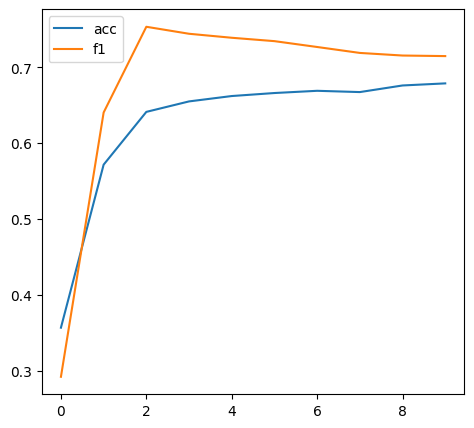

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(scoreList[1], label="acc")
plt.subplot(121)
plt.plot(scoreList[2], label="f1")
plt.legend()
plt.show()
